In [1]:
import tensorflow as tf
from tensorflow.python.tools import freeze_graph
from tensorflow.python.framework import graph_util
import numpy as np
from IPython.display import Image,display
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

path = '/home/mady/Desktop/Deep-math-machine-learning.ai/Meetups_Notebooks/Neural_Network_End2End/model_outputs/'

In [2]:
tf.logging.set_verbosity(tf.logging.ERROR)

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [3]:
train_X = mnist.train.images
train_Y = mnist.train.labels
test_X = mnist.test.images
test_Y = mnist.test.labels

# train_X = train_X.reshape(-1,28,28,1) #reshape as images
# test_X = test_X.reshape(-1,28,28,1)

In [4]:
train_X.shape

(55000, 784)

In [5]:
print("training images shape (no of images, size of an image)")
print(train_X.shape,train_Y.shape)

training images shape (no of images, size of an image)
(55000, 784) (55000,)


In [6]:
train_X[1].shape

(784,)

In [7]:
image = train_X[1]

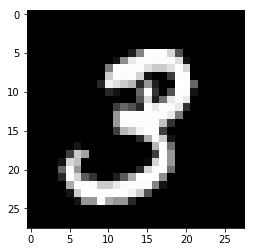

In [8]:
def visual_single_image(image):
    image= np.squeeze(image.reshape(28,28,1),axis=2)
    plt.imshow(image,cmap='gray')
    plt.show()

visual_single_image(image)

Training Images


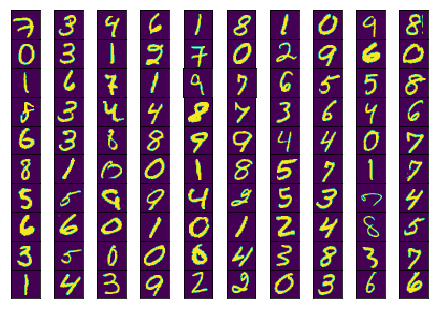

In [9]:
def visualize_mnist(images):
    dim = images.shape[0]
    n_image_rows = int(np.ceil(np.sqrt(dim)))
    n_image_cols = int(np.ceil(dim * 1.0/n_image_rows))
    gs = gridspec.GridSpec(n_image_rows,n_image_cols,top=1., bottom=0., right=1., left=0., hspace=0., wspace=0.)
    
    for g,count in zip(gs,range(int(dim))):
        ax = plt.subplot(g)
        ax.imshow(images[count,:].reshape((28,28)))
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()


print("Training Images")
visualize_mnist(train_X[:100])

In [10]:
train_Y[:100]

array([7, 3, 4, 6, 1, 8, 1, 0, 9, 8, 0, 3, 1, 2, 7, 0, 2, 9, 6, 0, 1, 6,
       7, 1, 9, 7, 6, 5, 5, 8, 8, 3, 4, 4, 8, 7, 3, 6, 4, 6, 6, 3, 8, 8,
       9, 9, 4, 4, 0, 7, 8, 1, 0, 0, 1, 8, 5, 7, 1, 7, 5, 5, 9, 9, 4, 2,
       5, 3, 7, 4, 6, 6, 0, 1, 0, 1, 2, 4, 8, 5, 3, 5, 0, 0, 6, 4, 3, 8,
       3, 7, 1, 4, 3, 9, 2, 2, 0, 3, 6, 6], dtype=uint8)

Data visulization is done 

In [11]:
input_size = 784
no_hidden_neurons = 625
no_classes = 10 

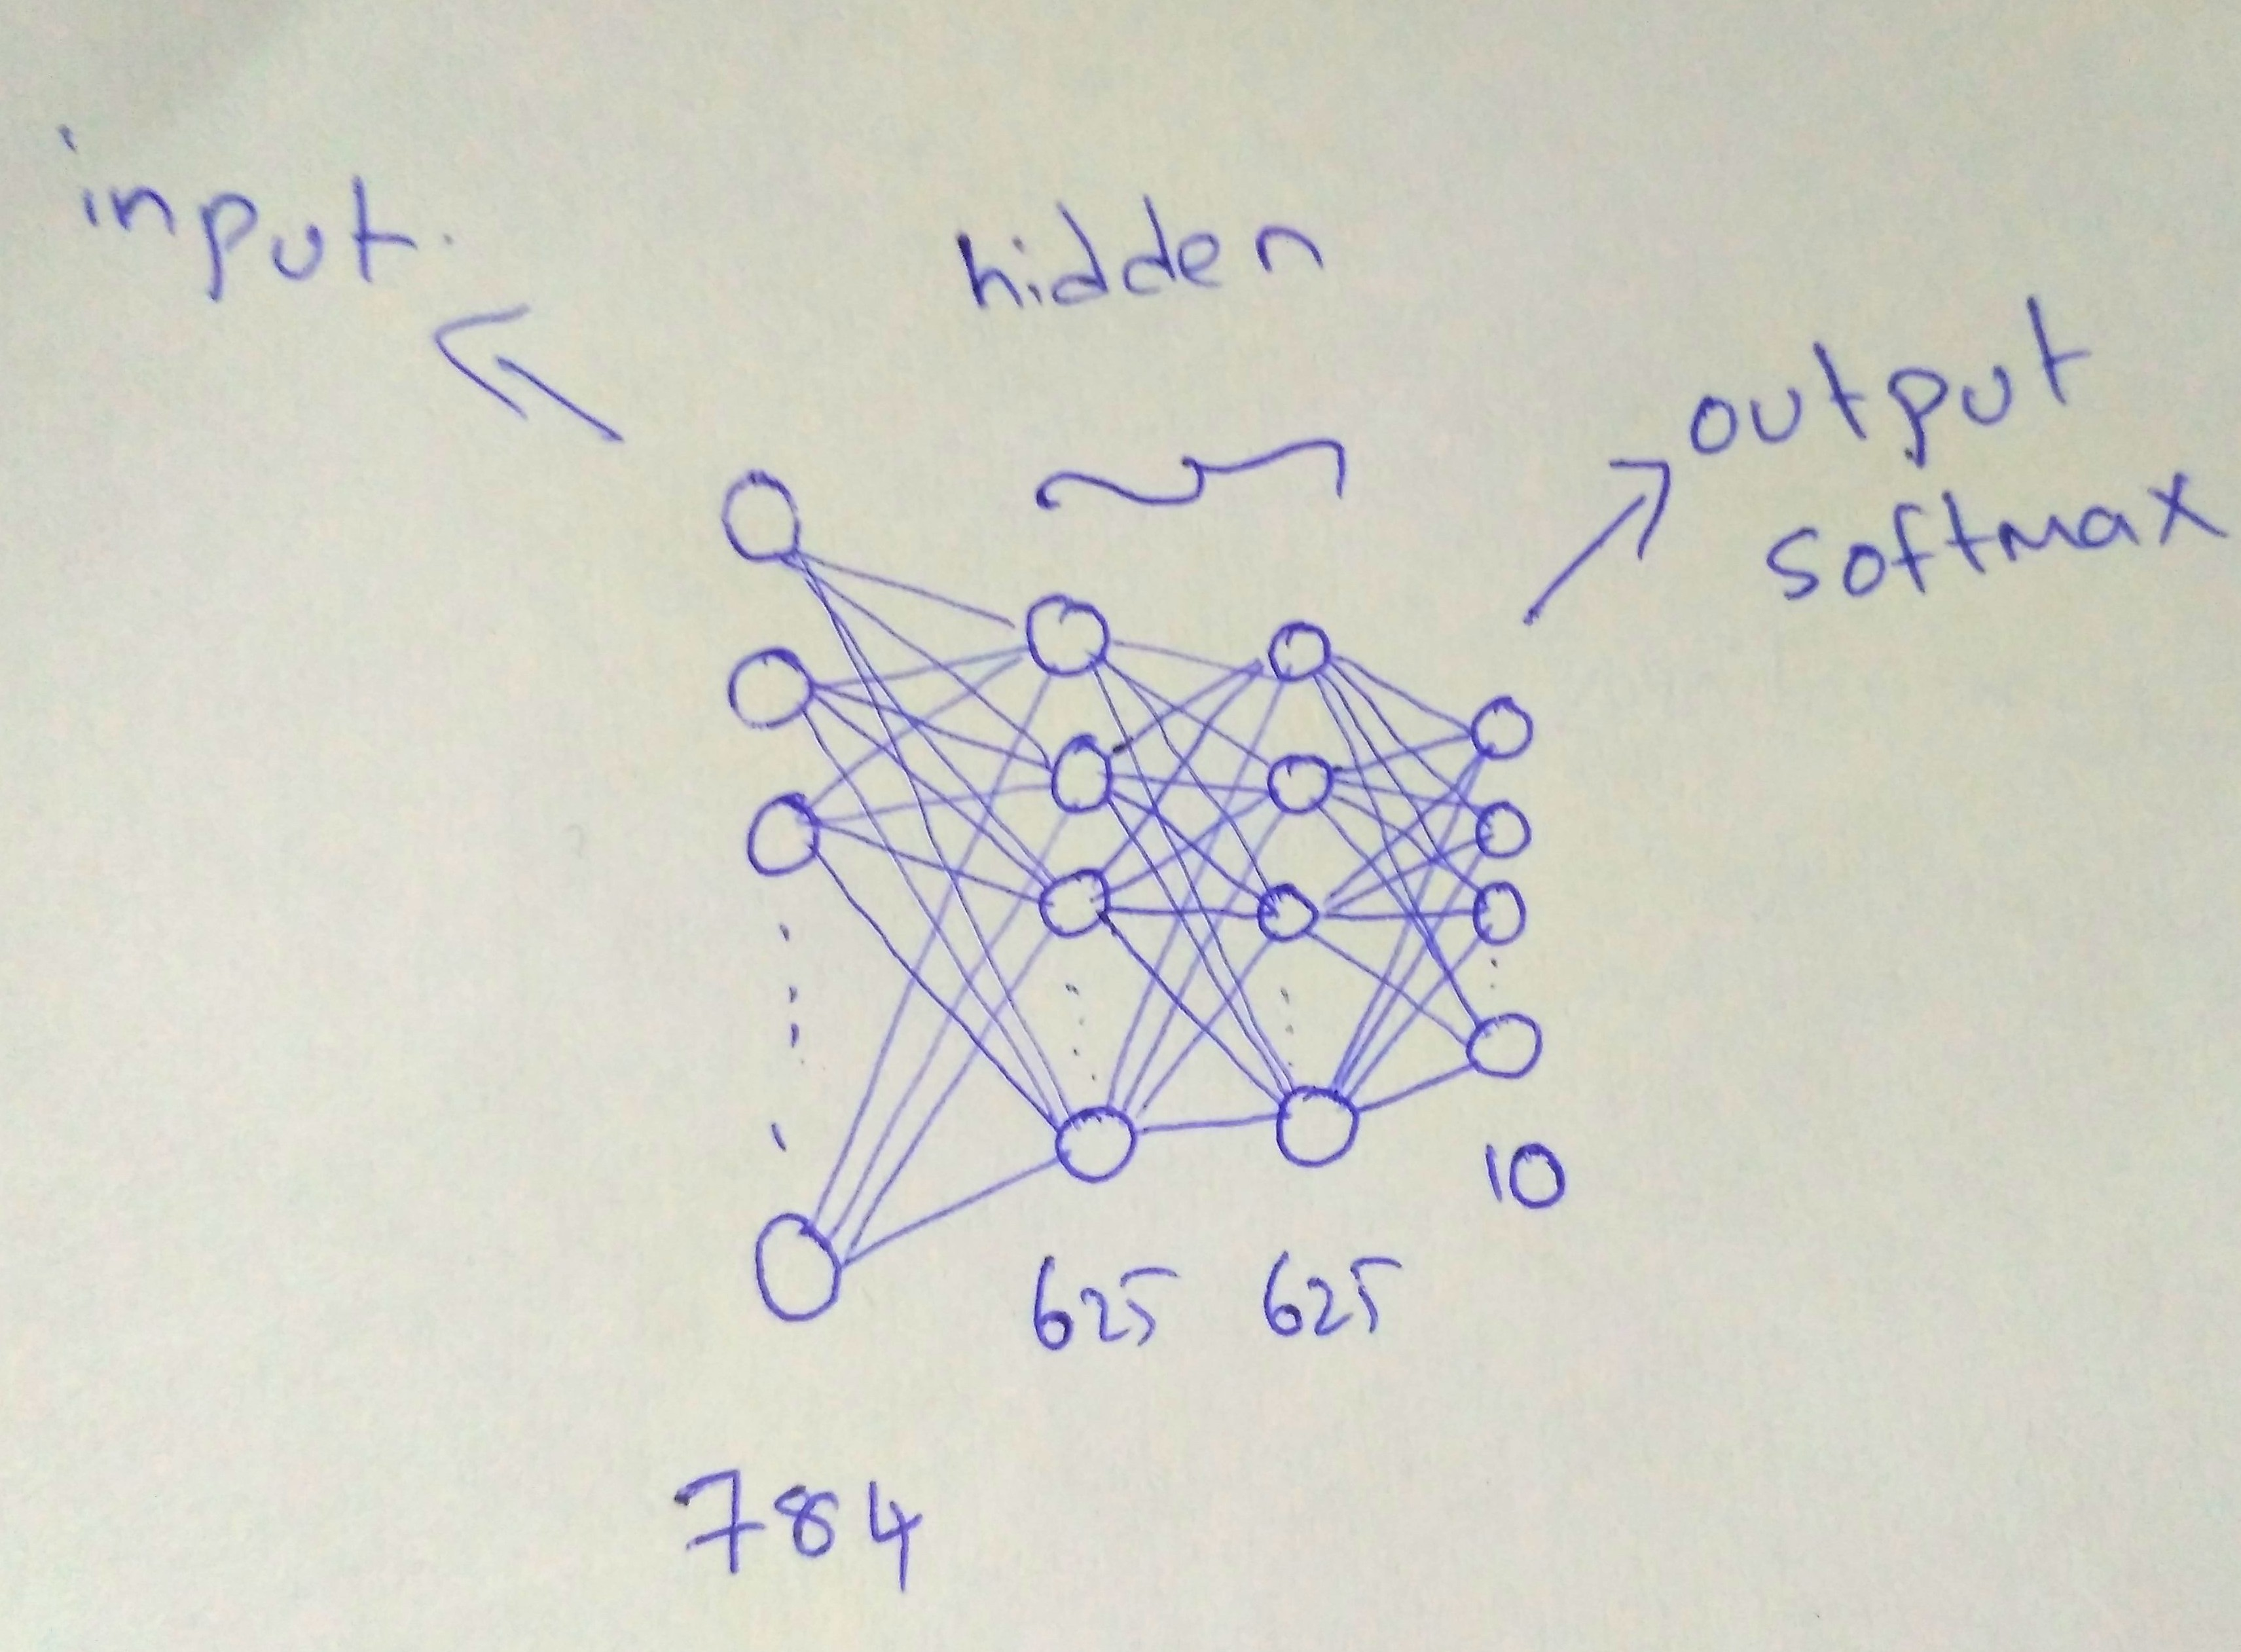

In [12]:
X = tf.placeholder("float", [None,input_size],name = "Inputs")# 784 featuress
Y = tf.placeholder("float", [None,no_classes]) # 10 classes

W_H1 = tf.Variable(tf.random_normal([input_size,no_hidden_neurons], stddev=0.01)) #784 * 625
W_H2 = tf.Variable(tf.random_normal([no_hidden_neurons,no_hidden_neurons],stddev = 0.01)) # 625*625
W_O = tf.Variable(tf.random_normal([no_hidden_neurons,no_classes], stddev=0.01))  # 625*10

def model(X, W_H1, W_H2, W_O):
        h1 = tf.nn.relu(tf.matmul(X, W_H1))
        h2 = tf.nn.relu(tf.matmul(h1,W_H2))
        return tf.matmul(h2,W_O)
    
display(Image("images/model.jpg",width=350,height=100))

In [13]:
total_params = input_size*no_hidden_neurons + no_hidden_neurons*no_hidden_neurons + no_hidden_neurons* no_classes
print("total no of weights are",total_params)

total no of weights are 886875


In [14]:
model_output_logits = model(X, W_H1, W_H2, W_O)

In [15]:
total_cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model_output_logits, labels=Y))

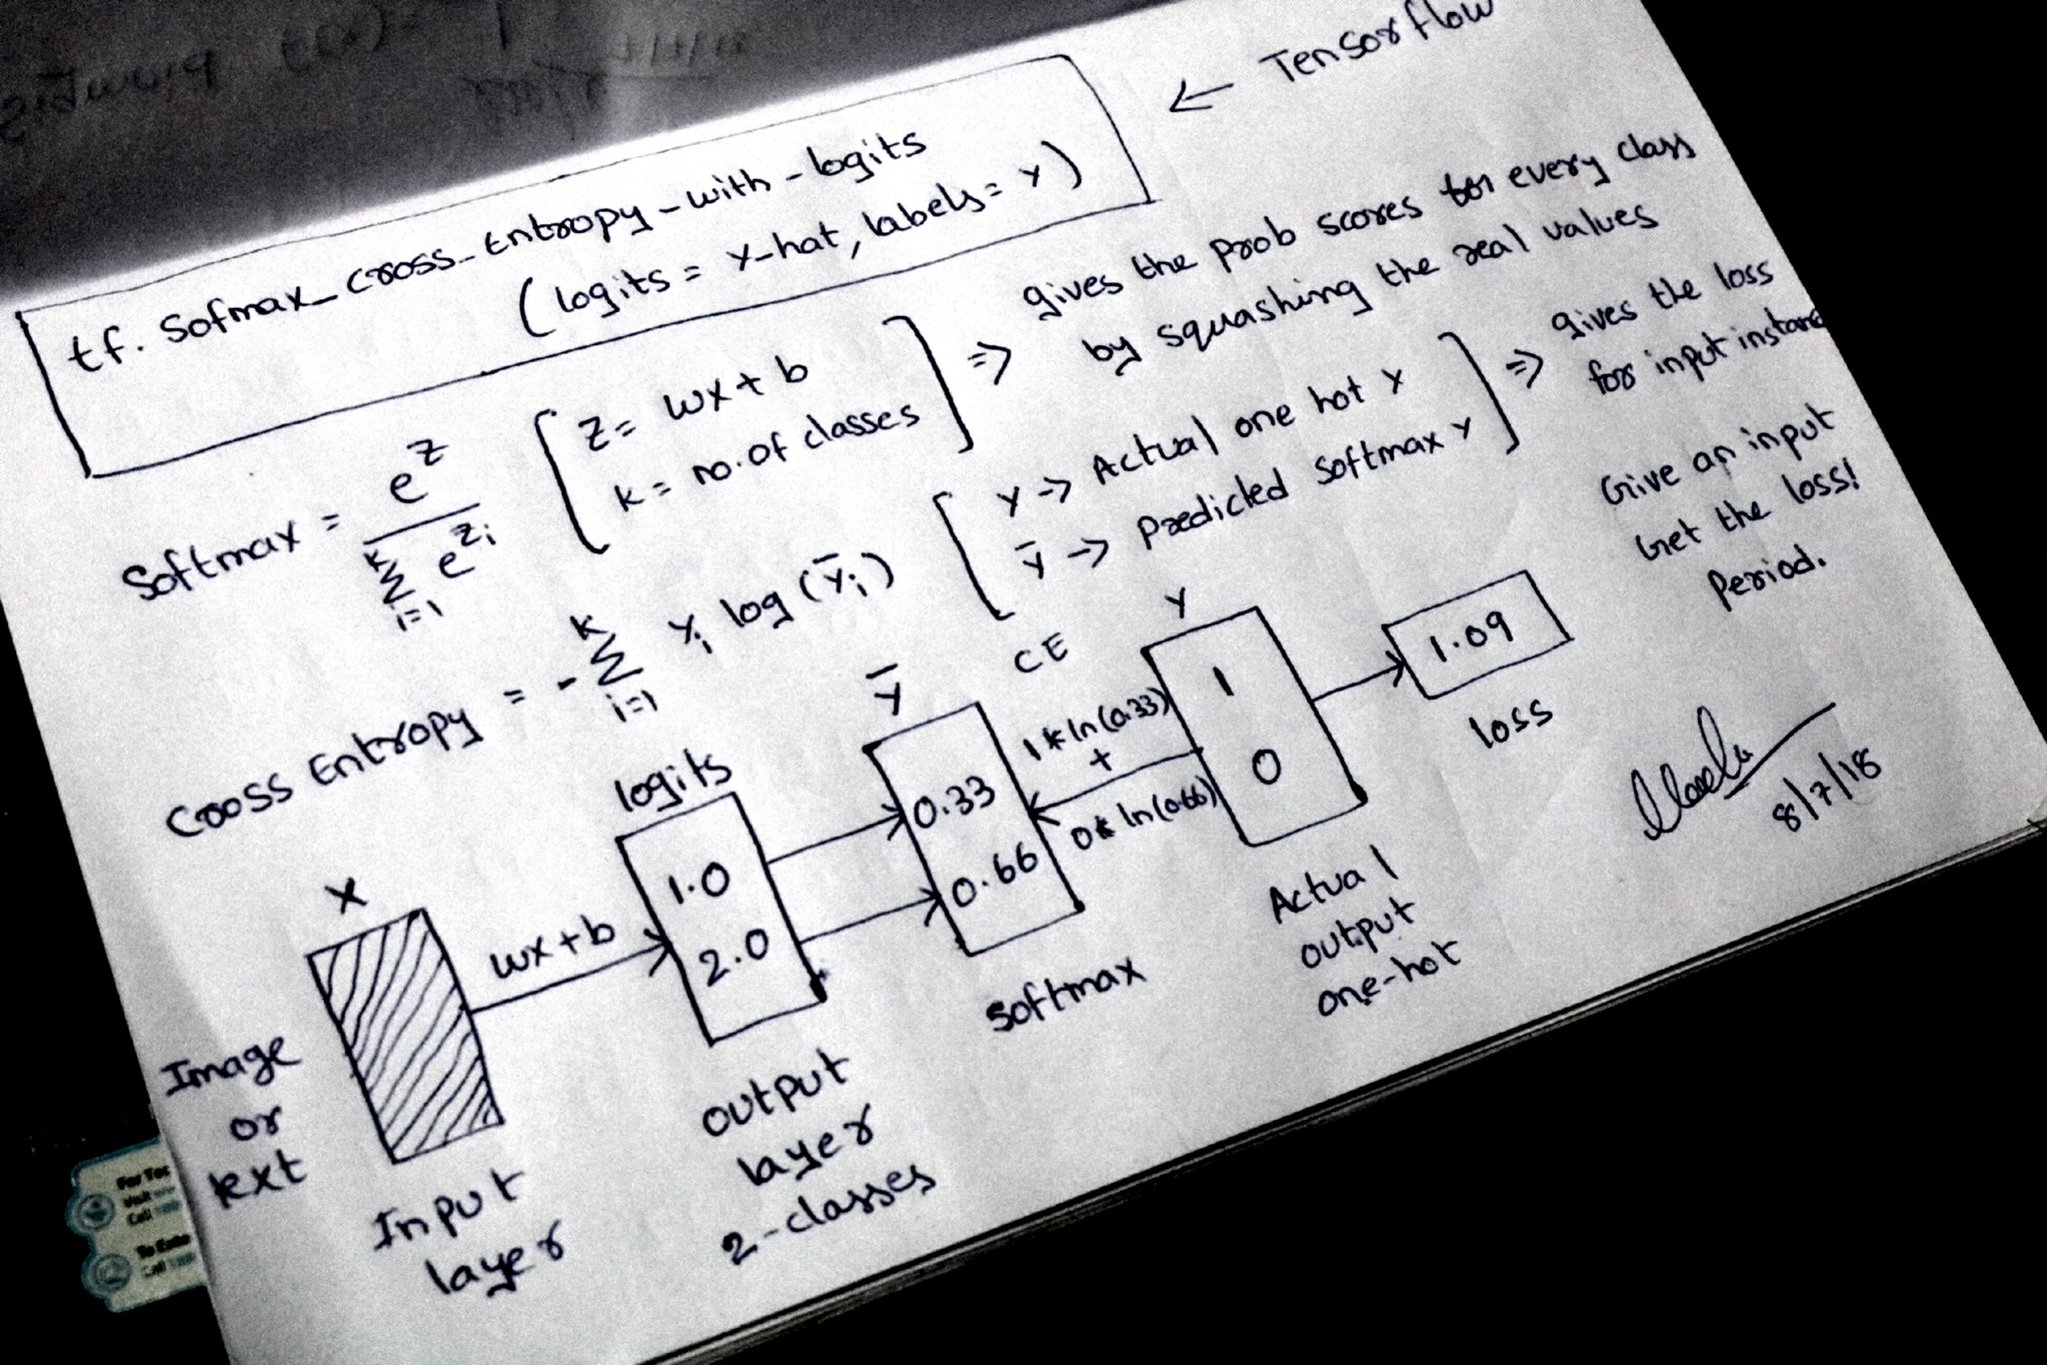

In [16]:
display(Image("images/instagram_notes.jpg",width=700,height=100))

In [17]:
optimizer=tf.train.GradientDescentOptimizer(0.05).minimize(total_cost)

In [18]:
predict_outputs_Y = tf.argmax(model_output_logits, 1,name = "Argmax",output_type=tf.int32) # at predict time, evaluate the argmax
# cast = tf.cast(predict_outputs_Y,tf.int32,name= "cast")
predict_softmaxs_Y = tf.nn.softmax(model_output_logits, 1,name ="Softmax")

In [19]:
def get_accuracy (inputs,labels,sess):
    return np.mean(np.argmax(labels, axis=1) == sess.run(predict_outputs_Y, feed_dict={X: inputs}))

In [20]:
def convert_to_onehot(targets):
    return np.eye(no_classes)[targets]

In [21]:
def save_tf_model(sess,path,model_name):

    tf.train.write_graph(sess.graph_def, '.', path+model_name+'.pbtxt')
    print("model protobuf is stored successfully!")

    saver = tf.train.Saver()
    saver.save(sess, path+model_name)
    print("model checkpoint is saved successfully!")


def freeze_tf_model(path,model_name):

    input_graph_path = path+model_name+'.pbtxt'
    checkpoint_path = path+model_name
    input_saver_def_path = ""
    input_binary = False
    output_node_names = "Argmax"
    restore_op_name = "save/restore_all"
    filename_tensor_name = "save/Const:0"
    output_frozen_graph_name = path+'frozen_'+model_name+'.pb'
    clear_devices = True

    freeze_graph.freeze_graph(input_graph_path, input_saver_def_path,
                              input_binary, checkpoint_path, output_node_names,
                              restore_op_name, filename_tensor_name,
                              output_frozen_graph_name, clear_devices, "")
    
    print("model is freezed successfully!")
    
def convert_to_tflite():
    converter = tf.contrib.lite.TocoConverter.from_frozen_graph(path+'frozen_mnist.pb', ['Inputs'], ['Argmax'])
    tflite_model = converter.convert()
    open(path+"mnist.tflite", "wb").write(tflite_model)
    print("Model is written as tflite")

In [22]:
train_Y_one_hot = convert_to_onehot(train_Y)
test_Y_one_hot = convert_to_onehot(test_Y)

In [23]:
epochs = 50
epoch_cost = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer()) #to initialize all the variables
    
    for epoch in range(epochs):
        
        total_batch_cost = 0
        
        for start, end in zip(range(0, len(train_X), 128), range(128, len(train_X)+1, 128)):
            feed_dict = {X : train_X[start:end] , Y : train_Y_one_hot[start:end]}
            _,batch_cost = sess.run([optimizer,total_cost],feed_dict=feed_dict)
            total_batch_cost += batch_cost
            
        epoch_cost.append(total_batch_cost)
        
        if epoch % 10 == 0:
            print()
            train_data_accuracy = get_accuracy(train_X,train_Y_one_hot,sess)
            test_data_accuracy = get_accuracy(test_X,test_Y_one_hot,sess)
            print("epoch : {}\n train accuracy : {}\n test accuracy : {} " .format(epoch, train_data_accuracy,test_data_accuracy))
            
    print()
    print("Training is done")
    test_predictions_Y = sess.run(predict_outputs_Y,feed_dict={X:test_X})
    test_predictions_softmax_Y = sess.run(predict_softmaxs_Y,feed_dict={X:test_X})

    save_tf_model(sess,path,"mnist")
    freeze_tf_model(path,"mnist")
    convert_to_tflite()
    


epoch : 0
 train accuracy : 0.7866727272727273
 test accuracy : 0.7924 

epoch : 10
 train accuracy : 0.9653090909090909
 test accuracy : 0.9621 

epoch : 20
 train accuracy : 0.9843272727272727
 test accuracy : 0.9738 

epoch : 30
 train accuracy : 0.9927090909090909
 test accuracy : 0.977 

epoch : 40
 train accuracy : 0.9970909090909091
 test accuracy : 0.979 

Training is done
model protobuf is stored successfully!
model checkpoint is saved successfully!
model is freezed successfully!
Model is written as tflite


In [24]:
print(epoch_cost)

[764.8428275287151, 215.82475288957357, 156.80627831816673, 135.1219285465777, 117.21797630935907, 100.98118191584945, 87.50236633978784, 76.94062991067767, 68.52659814245999, 61.58623493090272, 55.717652317136526, 50.69027325697243, 46.34087810944766, 42.52797670662403, 39.16627442743629, 36.15272028837353, 33.45154532697052, 31.006101170554757, 28.788067896384746, 26.780684637837112, 24.935571247711778, 23.239129373803735, 21.680096430238336, 20.23694986384362, 18.89988009026274, 17.66656101308763, 16.514035226311535, 15.443184738978744, 14.444218314252794, 13.513607130851597, 12.638464592164382, 11.824584276881069, 11.061883934773505, 10.355615845415741, 9.685735898092389, 9.068185604410246, 8.49110310850665, 7.945532168727368, 7.443180595408194, 6.977528492338024, 6.549584299791604, 6.146652880590409, 5.781071442645043, 5.43908881850075, 5.124241847661324, 4.831900344463065, 4.560920954449102, 4.307114649796858, 4.071101950365119, 3.853593881474808]


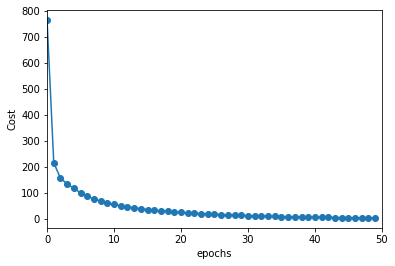

In [25]:
def visulize_cost(epoch_cost):
    indices = [i for i in range(len(epoch_cost))]
    plt.plot(indices,epoch_cost,marker="o")
    plt.xlabel("epochs")
    plt.ylabel("Cost")
    plt.xlim(0, len(indices))
    plt.show()
visulize_cost(epoch_cost)

Testing Images


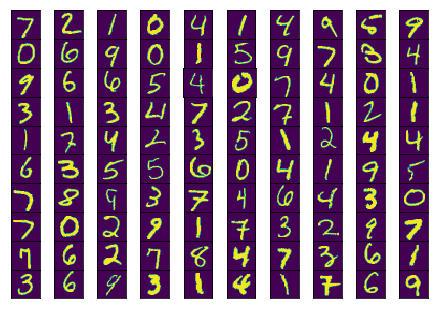

In [26]:
print("Testing Images")
visualize_mnist(test_X[:100])

In [27]:
test_predictions_Y[:100]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6,
       6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2,
       3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4,
       6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3,
       6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9], dtype=int32)

In [28]:
test_predictions_Y[:100] == test_Y[:100]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [29]:
test_predictions_softmax_Y

array([[1.8503106e-09, 4.5054169e-09, 1.6549162e-06, ..., 9.9997115e-01,
        5.6602065e-09, 8.8059568e-07],
       [3.5682096e-08, 2.2910044e-05, 9.9997330e-01, ..., 1.0597253e-12,
        1.1559329e-06, 3.2081140e-16],
       [3.9286268e-09, 9.9926478e-01, 1.7082739e-05, ..., 2.0863539e-04,
        4.3634704e-04, 6.3022497e-08],
       ...,
       [5.7854124e-16, 1.6297737e-11, 2.6753808e-16, ..., 2.7945392e-08,
        1.8526233e-09, 4.7735585e-07],
       [1.7638705e-09, 2.4459157e-11, 8.0840435e-15, ..., 1.6557358e-13,
        1.2169036e-06, 2.5244756e-12],
       [7.6263706e-09, 2.9132485e-13, 1.9824464e-09, ..., 7.6667394e-17,
        2.2118983e-10, 9.1831653e-14]], dtype=float32)

# Prediction from .pb file

import/Inputs
import/Variable
import/Variable/read
import/Variable_1
import/Variable_1/read
import/Variable_2
import/Variable_2/read
import/MatMul
import/Relu
import/MatMul_1
import/Relu_1
import/MatMul_2
import/Argmax/dimension
import/Argmax


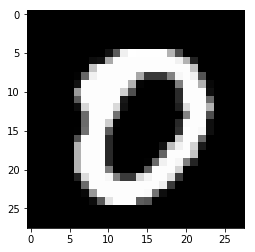

The Number is  [0]


In [63]:
def load_graph(frozen_graph_filename):
    with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
    return graph

graph = load_graph(path+'frozen_mnist.pb')
# for op in graph.get_operations():
#     print(op.namgbe)
x = graph.get_tensor_by_name('import/Inputs:0')
y = graph.get_tensor_by_name('import/Argmax:0')

image = train_X[120]
visual_single_image(image)
image = np.expand_dims(image,axis=0)

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    output = sess.run([y],feed_dict={x:image})
    print("The Number is ",output[0])
    

In [31]:
output[0].dtype

dtype('int32')

In [32]:
output[0].dtype

dtype('int32')